# Equivariant Neural Rendering

## Imports
- Import git modules & stuff

In [ ]:
import random, os, sys
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
%matplotlib inline
import imageio
import torch
import torchvision
from torchvision.transforms import ToTensor


sys.path.append('/content/equiv-neural-rendering/')
from models.neural_renderer import *


### Loading and plotting the original image

/tmp/ipykernel_7485/1697552612.py:24: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread( path)


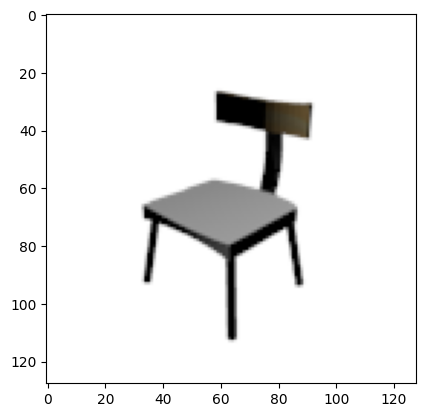

In [ ]:
""" Detect local path """
local_path = !pwd
local_path = local_path[0]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def plot_img_tensor(img, nrow=4):
    """Helper function to plot image tensors.
    
    Args:
        img (torch.Tensor): Image or batch of images of shape 
            (batch_size, channels, height, width).
    """
    img_grid = torchvision.utils.make_grid(img, nrow=nrow)
    plt.imshow(img_grid.cpu().numpy().transpose(1, 2, 0))

# Load trained chairs modellocal_path
path = local_path + '/trained-models/chairs.pt'
model = load_model(path).to(device)

# You can also try loading other examples (e.g. 'chair1.png')
path  = local_path + '/imgs/example-data/chair4.png'
img = imageio.imread( path)
# Visualize image
plt.imshow(img)

### Rendering the scene reprensentation without rotation and translation

In [ ]:
# Convert image to tensor and add batch dimension
img_source = ToTensor()(img)
img_source = img_source.unsqueeze(0).to(device)

# Infer scene representation
scene = model.inverse_render(img_source)

# We can render the scene representation without rotating it
rendered = model.render(scene)

plot_img_tensor(rendered.detach())

org = rendered.detach().clone()

### Rotating and translating the scene reprensentation and rendering a novel view

In [ ]:
# As a rotation matrix can feel a little abstract, we can also reason in terms of 
# camera azimuth and elevation. The initial coordinate at which the source image
# is observed is given by the following azimuth and elevation. Note that these
# are not necessary to generate novel views (as shown above), we just use them 
# for convenience to generate rotation matrices
azimuth_source = torch.Tensor([0.]).to(device)
elevation_source = torch.Tensor([0.]).to(device)
translations_source = torch.Tensor([0., 0., 0.]).to(device)

# You can set these to any value you like!
# Positive (negative) values correspond to moving camera to the right (left)
azimuth_shift = torch.Tensor([0.]).to(device)  
# Positive (negative) values correspond to moving camera up (down)
elevation_shift = torch.Tensor([0.]).to(device)
# Translation values
translations_shift = torch.Tensor([0., -0.5, 0.]).to(device)

azimuth_target = azimuth_source + azimuth_shift
elevation_target = elevation_source + elevation_shift
translations_target = translations_source + translations_shift

# Rotate scene to match target camera angle
rotated_scene = model.rotate_source_to_target(
    scene, 
    azimuth_source, elevation_source, translations_source,
    azimuth_target, elevation_target, translations_target
)

# Render rotated scene
rendered = model.render(rotated_scene)

plot_img_tensor(rendered.detach())

## 1. Introduction

*analysis of key components*

### 1.1: Intro
The paper from Dupont et al. introduces an approach to render 2D images into implicit, equivariant 3D representations. The authors argue that the scene representations need not be explicit, as long as the transformations to it occur in an equivariant manner. Their model is trained on a dataset of rotation symmetries, learning to produce novel views from a single image of a scene.

Current approaches in scene representations present difficulties with scalability. Voxel grids, point clouds and other traditional methods have high computational and memory requirements. Reconstrucion from incomplete or noisy data is also a challenging task with these methods, often requiring 3D information during training. Generating novel views of a scene given some input views presents the same difficulties. Finally, traditional neural networks are not equivariant with respect to general transformation groups. 3D equivariance especially requires specifc techniques like steerable filters. The authors attempt to solve these problems by proposing a new method which results in more scalable, implicit representations that are also equivariant with respect to transformations. 

The difference between an explicit scene representation (mesh grid) and an implicit one can be seen in the figure below:

![Alt text](figg2.png)

  
### 1.2: Methodology

The proposed model uses a series of convolutions to map scene representations to images. Specifically, the scene representation is passed through 3D convolutions, followed by 1x1 convolutions and a set of 2D convolutions that maps them to image space. The reverse renderer is the transpose of this operation. Equivariance is enforced by applying transformations in both the scene and image spaces. Because the representation space is a deep voxel grid, the transformations in this space are defined by a 3D rotation matrix. Inverse warping with trilinear interpolation is also used in the model, to reconstruct the values after rotations.

![Alt text](fig5.png)

For training, two images of the same scene are passed through the renderer. Then, the 3D transformation grid is applied in the representation space to turn one into the other, before passing them to the inverse renderer. Finally, the output images are compared to the original inputs to obtain the loss values. Training in this manner ensures the model learns equivariant representations, as the loss evaluates both the actual rendering and the accuracy of the matching transformations from both spaces.

![Alt text](fig4.png)

Finally, the authors claim that the rendering loss used makes little change in results. They provide l1 norm, l2 norm and SSIM loss as candidates, and conduct ablation studies to determine the tradeoffs between them.

### 1.3: Datasets
The authors evaluate their model on 4 datasets, including two ShapeNet benchmarks as well as two novel datasets of the authors design. They use an image size of 128 x 128 and a representation size of 64 x 32 x 32 x 32.
The datasets are presented in table 1. 


| *Dataset*  | *Source*  |  *Sample* | *# Scenes*  |*# images per scene*| *# datapoints*|
|---|---|---|---|---||
| Chairs  | [ShapeNet](https://icml20-prod.cdn-apple.com/eqn-data/data/chairs.zip)  | ![Chair](imgs/paper/chair.png)  |  6591 | 50  | 329 550|
| Cars  |  [ShapeNet](https://icml20-prod.cdn-apple.com/eqn-data/data/cars.zip) | ![Car](imgs/paper/car.png)  |  3514 |  50 | 175 700|
| MugsHQ  |  [Apple](https://icml20-prod.cdn-apple.com/eqn-data/data/mugs.zip) | ![Mug](imgs/paper/mug.png)  |  214 | 150  | 32 100|
| 3D mountainset  |  [Apple](https://icml20-prod.cdn-apple.com/eqn-data/data/mountains.zip) | ![Mountain](imgs/paper/mountain.png)  |  559 |  50 | 27 950|

Table 1.: *Overview of datasets considered for equivariant neural rendering by Dupont et al.*

### 1.4: Experiments of paper

The proposed model is compared against three baseline models, each one making assumptions much stronger than the original study.

|   | TCO  |  DGQN | SRN  | Proposed model  |
|---|---|---|---|---|
| Requires Absolute Pose  | Yes  | Yes | Yes | No |
| Requires Pose at Inference Time  | No  | Yes | Yes | No |
| Optimization at Inference Time  | No  | No | Yes | No |

The qualitative comparisons against the baseline models in single shot novel view synthesis with the ShapeNet chairs dataset reveals that the model achieves similar to SoTA results while making far fewer assumptions than the other methods. It can produce high quality novel views by achieving the desired equivariant transformation in representation space.

![Alt text](results.png)

Results similar to the chairs were reported in the other datasets, with some variations due to the specific challenges of each one. For example, the mountains contain extremely complex geometric information, which severly limits the detail of the novel view synthesis.

![Alt text](chairs.png) 

Finally, the authors performed ablation studies to test novel view synthesis when using different loss functions. The results in each one were similar and no inherent prefered approach was suggested. In the end, they reason that choice of loss function is task specific.

## 2. Response 

Much of the success of Deep Learning can be attributed to effective representation learning. Such representations do not need to be humanly interpretable, but can also be abstract. The original authors proposed an implicit 3D representation of the scene, instead of an explicit 3D representation such as mesh-grids or point clouds. By removing the need for an explicit 3D representation, they developed a model that requires no 3D supervision. It only requires 2D images with the corresponding rotation angle of the camera, that was used between these images. Their model can generate a novel view from a single image. The qualitative results of their model’s performance motivated us to extent their research.

In the original paper the authors used 3D rotations to generate novel views, meaning that they rotate a camera on a sphere around the scene. 3D rotations do not act transitively on 3D space. Therefore, we proposed to extend their model to roto-translations, with the intermediate proof-of-concept step of using translations only. The objective was to obtain a model that can generate a novel view for any camera position in 3D space, within a reasonable range of movement.

## 3. Novel Contribution
- Describe your novel contribution.
* Methodology/theory for translation & rototranslations
  - justify group representation (homogeneous coords for translation and order of matrix multiplcation. 

- Support your contribution with actual code and experiments (hence the colab format!)
  - Demotime







### 3.1 Datasets

The authors present datasets consisting of rotational transformations. However, they do not provide instructions or tools for further data generation. To address this limitation we developed a new pipeline using blender for producing images of 3D-models under rotations, translations and roto-translations. Our pipeline can be used to increase the size of the training data, or to extend training data to new transformation groups.

The following section demonstrates the practical application of our pipeline for data production, enabling the generation of new training data for training translation and roto-translational invariant rendering models.

#### 3.1.1 Selecting 3D models
Similar to the authors, we perform experiments on ShapeNet benchmark. In particular, we download the [ShapeNet Core](https://shapenet.org/download/shapenetcore) subset. It is worth noting that the objects included in the ShapeNetCore dataset are already normalized and consistently aligned. From this subset we extract 2637 models.

#### 3.1.2 Build dataset with blender 

The subsequent pipeline can be adapted to accommodate any 3D-object data that is processable by Blender. Here follows a brief demonstration of how the pipeline can be used using blender 2.8. 


In [ ]:
""" Detect local path """
local_path = !pwd
local_path = local_path[0]

_Run the subsequent cells once to install Blender with wget_



In [ ]:
""" Install / Load wget """
%pip install wget
import wget

""" Install blender """
# Download blender 3.5.1
!wget https://ftp.nluug.nl/pub/graphics/blender/release/Blender3.5/blender-3.5.1-linux-x64.tar.xz

# Unpack 
!tar -xvf blender-3.5.1-linux-x64.tar.xz
!rm {local_path}/blender-3.5.1-linux-x64.tar.xz

# Move and rename for shorter commands
!mv {local_path}/blender-3.5.1-linux-x64 {local_path}/data_prep/demo/blender


_Run render demo_

In [ ]:
""" Run Demo"""
!{local_path}/data_prep/demo/blender/blender -b --python data_prep/demo/render_blender.py -- --scene_name data --rotation --translation --scene_folder /data_prep/demo/data/model_1 --local_path {local_path}

_Display visual demonstration of roto-translation dataset_

In [ ]:
""" Display random sample outputs """
# Load 3 random images from output directory
path = local_path + "/data_prep/demo/output/rot_trans_dataset/data/"
random_file = [random.choice(os.listdir(path)) for img in range(3)]
images = [mpimg.imread(path + image) for image in random_file]

# Plot sampleset
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
for ax, id in zip(axs, range(3)):
    ax.imshow(images[id])
plt.show()



#### 3.1.3 New datasets

We first reproduce a rotation dataset which we train a model on to verify the reproducibility of the authors orginial results.

Subsequently, we produce two new datasets incorporating translations and roto-translations. 

|   | *# Scenes*  |  *# Images per scene* | Resolution  | *# datapoints*  |
|---|---|---|---|---|
| Train  | 2306  |  50 | 64 x 64  |  115300 |
| Validataion  | 331  | 50  |  64 x 64 | 16550  |

The rotations are sampled uniformly on a sphere with radius 1.5

We generate 50 images per object by applying transformations rotations, translations, and roto-translations.



The following section demonstrates the practical application of our pipeline for data production, enabling the generation of new training data for future research purposes.

Include:
- blender
- further applications using framework 
- demo of production of new datasets 

## 4. Conclusion

- Some preliminary results (working model)

## 5. Contributions 

Close the notebook with a description of the each students' contribution.